In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
def load_HR_data(filename):
    #This function is used to load and clean data
    
    df = pd. read_csv(filename, sep='\s+', names=list(range(54)))
    #obtain the HR data and drop rows with missing data
    #according to the experiemental protocol, Activity type 0 should be removed for analysis
    #df = df[df.loc[:,1]!=0]
    df_sub = df.loc[:,0:2]
    df_sub.dropna(inplace=True)
    
    return df_sub

def signal_reconstruct(df,l_segment=27,l_slide=9):
    #This function is used to reconstruct the signal using k-means clustering
    
    HR = df.loc[:,2].values
    segments = []
    time_frame = []
    
    #divide the signal into small segments
    for pos_start in range(0, len(HR), l_slide):
        pos_end = pos_start + l_segment
        segment = np.copy(HR[pos_start:pos_end])
        
        if len(segment) != l_segment:
            continue
        segments.append(segment)
        time_frame.append(list(range(pos_start, pos_end)))

    #k means clustering to group different signal segments
    num_clusters = len(np.unique(df.loc[:,1]))
    
    clusterer = KMeans(n_clusters=num_clusters)
    clusterer.fit(segments)
    
    centroids = clusterer.cluster_centers_

    #reconstruct the signal by stiching the segments
    n = time_frame[-1][-1]+1
    rec = np.zeros(n)    
    for i in range(len(segments)):
        segment = np.copy(segments[i])
        
        nearest_centroid_idx = clusterer.predict([list(range(l_segment)), segment])
        nearest_centroid = np.copy(centroids[nearest_centroid_idx])
        
        # stitch the reconstructed segments with overlap
        pos = time_frame[i][0]
        rec[pos:pos+l_segment] = nearest_centroid[1]
        
    return rec


def error_anomaly(HR, rec, scale=10):
    # this function is used to detect anomaly based on reconstruction error
    error = pd.DataFrame(rec-HR[0:len(rec)])
    #error stats
    error_std = np.std(error)
    error_avg = np.mean(error)
    #upper and lower boundaries
    upper = error_avg+scale*error_std
    lower = error_avg-scale*error_std
    #identify anomaly 
    upper_anomaly = (np.array(error)>upper.values)
    lower_anomaly = (np.array(error)<lower.values)
    anomaly = upper_anomaly | lower_anomaly
    
    return anomaly
    

def plot_sig_rec_err(HR, rec, df, anomaly, subject_num):
    #this function is used to plot the original signal, reconstructed signl, error and anomaly
    error = rec-HR[0:len(rec)]
    #time = df.loc[:,0]
    time_points = list(range(len(rec)))
    plt.plot(time_points, HR[0:len(rec)], label="Original")
    plt.plot(time_points, rec, label="Reconstructed")
    plt.plot(time_points, error, label="Reconstruction Error")
    error = pd.DataFrame(error)
    plt.plot(error[anomaly],marker = '.',color ='r',label='Anomalies')
    plt.title('Subject '+str(subject_num))
    plt.xlabel('Time Point')
    plt.ylabel('Heart Rate')

In [4]:
#subject 105
df_105 = load_HR_data('subject105.dat')
rec_105 = signal_reconstruct(df_105)
HR_105 = df_105.loc[:,2].values
anomaly_105 = error_anomaly(HR_105, rec_105)

In [5]:
#subject 106
df_106 = load_HR_data('subject106.dat')
rec_106 = signal_reconstruct(df_106)
HR_106 = df_106.loc[:,2].values
anomaly_106 = error_anomaly(HR_106, rec_106)

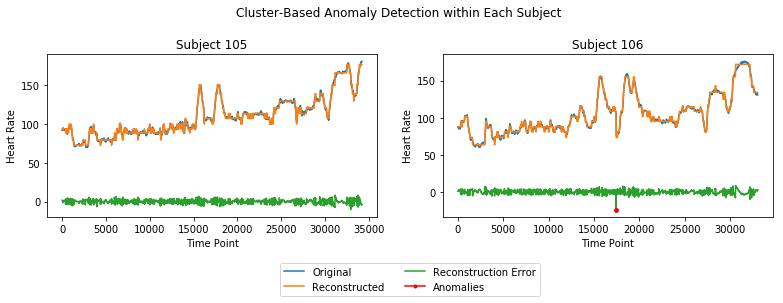

In [6]:
#plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.2)
plt.subplot(1, 2, 1)
plot_sig_rec_err(HR_105, rec_105, df_105, anomaly_105, 105)

plt.subplot(1, 2, 2)
plot_sig_rec_err(HR_106, rec_106, df_106, anomaly_106, 106)

fig.set_figheight(3)
fig.set_figwidth(13)
plt.suptitle('Cluster-Based Anomaly Detection within Each Subject',fontsize=12,x=0.5,y=1.1)
plt.legend(loc=9, bbox_to_anchor=(-0.1, -0.25), ncol=2)
plt.show()